# **recurrent neural network**

### init

In [1]:
import torch
from utils.data_util import HackerNewsContext
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

torch.manual_seed(0)

class InputLayer(nn.Module):
    def __init__(self, context_size, embedding_dims, device):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.context_size = context_size
        self.device = device
        self.C = nn.Parameter(torch.randn((28, self.embedding_dims), device=self.device) * 0.01) # embedding lookup-table

    def forward(self, X):
        # X comes in as (batch_size, context_size, 28)
        embeddings = X @ self.C # (batch_size, context_size, embedding_dims)
        return embeddings
    
class RNNLayer(nn.Module):
    def __init__(self, context_size, input_size, output_size, device):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.device = device
        self.Wxh = nn.Parameter(torch.randn((self.input_size, self.output_size), device=self.device) * (2/(self.input_size))**0.5) # weights input to hidden
        self.Whh = nn.Parameter(torch.randn((self.output_size, self.output_size), device=self.device) * (2/self.output_size)**0.5) # weights hidden to hidden
        self.bh = nn.Parameter(torch.randn((1, self.output_size), device=self.device) * 0.01) # biases hidden layer

    def forward(self, X):
        # X comes in as (batch_size, context_size, input_size)
        hs = {}
        hs[-1] = torch.zeros(X.shape[0], self.output_size, device=self.device)

        for t in range(self.context_size):
            hs[t] = F.tanh(X[:, t, :] @ self.Wxh + hs[-1] @ self.Whh + self.bh) # (batch_size, output_size)

        out = torch.stack(tuple(hs.values())[1:], dim=1)
        return out
    
class OutputLayer(nn.Module):
    def __init__(self, context_size, input_size, device):
        super().__init__()
        self.input_size = input_size
        self.context_size = context_size
        self.device = device        
        self.Who = nn.Parameter(torch.randn((self.input_size, 28), device=self.device) * (2/self.input_size)**0.5) # weights hidden to output
        self.bo = nn.Parameter(torch.randn(28, device=self.device) * 0.01) # biases output layer

    def forward(self, X):
        # X comes in as (batch_size, context_size, input_size)
        out = F.sigmoid(X @ self.Who + self.bo) # (batch_size, context_size, 28)
        return out
    

class Net(nn.Module):
    def __init__(self, context_size, embedding_dims, hidden_units, device):
        super().__init__()
        self.context_size = context_size
        self.embedding_dims = embedding_dims
        self.hidden_units = hidden_units
        self.device = device
        self.input_layer = InputLayer(context_size=self.context_size, embedding_dims=self.embedding_dims, device=self.device)
        self.rnn1 = RNNLayer(context_size=self.context_size, input_size=self.embedding_dims, output_size=self.hidden_units, device=self.device)
        self.rnn2 = RNNLayer(context_size=self.context_size, input_size=self.hidden_units, output_size=self.hidden_units, device=self.device)
        self.rnn3 = RNNLayer(context_size=self.context_size, input_size=self.hidden_units, output_size=self.hidden_units, device=self.device)
        self.rnn4 = RNNLayer(context_size=self.context_size, input_size=self.hidden_units, output_size=self.hidden_units, device=self.device)
        self.rnn5 = RNNLayer(context_size=self.context_size, input_size=self.hidden_units, output_size=self.hidden_units, device=self.device)
        self.output_layer = OutputLayer(context_size=self.context_size, input_size=self.hidden_units, device=self.device)

    def forward(self, X):
        # X comes in as (batch_size, context_size, 28)
        out = self.input_layer(X) # (batch_size, context_size, embedding_dims)
        out = self.rnn1(out) # (batch_size, context_size, hidden_units)
        out = self.rnn2(out) # (batch_size, context_size, hidden_units)
        out = self.rnn3(out) # (batch_size, context_size, hidden_units)
        out = self.rnn4(out) # (batch_size, context_size, hidden_units)
        out = self.rnn5(out) # (batch_size, context_size, hidden_units)
        out = self.output_layer(out) # (batch_size, context_size, 28)
        return out

Using mps device


### initialize hyperparameters, fetch training data

In [2]:
embedding_dims = 8
context_size = 12
batch_size = 256
hidden_units = 64
epochs = 10
max_grad = 5.0

In [3]:
training_data = HackerNewsContext(train=True, context_size=context_size, number_of_strings=10000)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)

### find initial learning rate

Text(0, 0.5, 'Cross Entropy Loss')

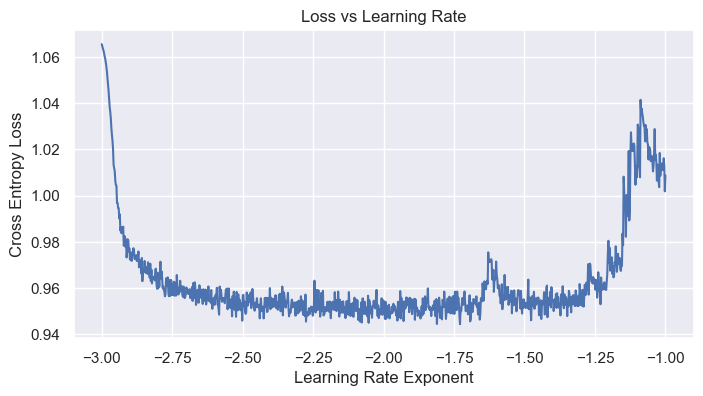

In [4]:
iterator = iter(train_dataloader)

rnn = Net(
    context_size=context_size,
    embedding_dims=embedding_dims,
    hidden_units=hidden_units,
    device=device
)
optimizer = optim.Adam(rnn.parameters())
loss_fn = nn.CrossEntropyLoss()

lr_exps = torch.linspace(-3, -1, 1000)
lrs = 10**lr_exps
losses = []

for lr in lrs:
    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    (X, y) = next(iterator)
    X, y = X.to(device), y.to(device)
    ypred = rnn(X)
    loss = loss_fn(ypred, y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=max_grad)
    optimizer.step()
    
fig, ax = plt.subplots(figsize=(8,4))
sns.set_style()
plt.plot(lr_exps, losses)
ax.set_title('Loss vs Learning Rate')
ax.set_xlabel('Learning Rate Exponent')
ax.set_ylabel('Cross Entropy Loss')

### reinstantiate rnn and optimizer

In [8]:
rnn = Net(
    context_size=context_size,
    embedding_dims=embedding_dims,
    hidden_units=hidden_units,
    device=device
)
optimizer = optim.Adam(rnn.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

### model training

In [9]:
for epoch in range(epochs):
    losses = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        ypred = rnn(X)
        loss = loss_fn(ypred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=max_grad)
        optimizer.step()
    print(f'epoch {epoch+1} --- avg loss {np.mean(losses)}')    

epoch 1 --- avg loss 0.9519764382848238
epoch 2 --- avg loss 0.9510424055403394


KeyboardInterrupt: 

### sample from model

In [10]:
context = ['<>'] * context_size
text = ''
for _ in range(300):
    with torch.no_grad():
        X = F.one_hot(torch.tensor([training_data.ctoi[c] for c in context], device=device), num_classes=28).view(1, context_size, 28).float()
        out = rnn(X) 
        char = training_data.itoc[torch.multinomial(out[:, -1, :].flatten(), 1).item()]
        if char == '<>':
            break
        context = context[1:] + [char]
        text += char

print(text)

puvayoxsikougonox waty avisquvisecechorinkicioxqles g bug frkinyseqlifilokigomalyplderypung cticlysqvior pifitory juvevevilavisplax m fanoxtho ctelongimyovakoksixplypenkomeve lduckorixadigumonsqusourkoroprojombl qleys if lditef ingorkowabindsinkioreriks ilevelowilincackofrequbixcouckoblyopoxquprysuv
